---
**The Best Model (Model 2 in our report)**: RandomForestRegressor with log transformation and upsampling and also feature engineering.


**To check the performance, simply run the following code cell, and result should be print out immediately.**

the code for plotting and visualisation are also followed

usually the code will load file named forstfires.csv in current directory or under data directory, still not found the code will download the data set from Haichen's Github.


File loaded locally! 
Start to fine tune a good parameters...


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSeachCV finished!  94.13625192642212 s used.
Start training our RandomForestRegressor(
	n_estimators=10, 
	max_depth=6)
Training finished! Start predicting...
The Performance of Our RandomForestRegressor:
MSE:   180.904
RMSE:  13.45
MAD:   1.598
MAE:   7.346
NLL:   1907.66
RR:    -0.095
AUC:   0.632
Total time cost in seconds:  94.18913888931274 s.


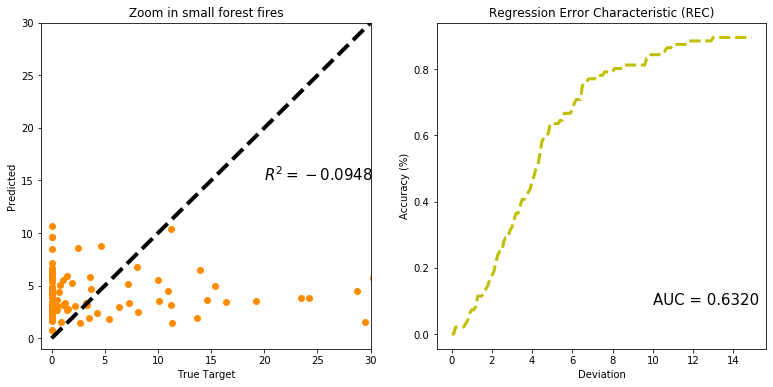

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import math
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics   
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.integrate import simps
import time
%matplotlib inline
# start the time clock
start_time = time.time()


def mean_absolute_deviation(y_predict):
    '''
    the mean absolue deviation of every prediction to the prediction mean, defined as:
    mean(abs(p - y_predict.mean() for p in y_predict))
    '''
    prediction_mean = np.mean(y_predict)
    distance = np.abs(y_predict - prediction_mean)
    return np.sum(distance) / len(y_predict)


def negative_log_likelihood(y_true, y_predict):
    '''
    defined as : −log𝑝(𝑦|𝐷,𝑥), 
    where y is the true value, D is the dataset, x represents a query point
    '''
    prediction_mean = np.mean(y_predict)
    prediction_variance = np.var(y_predict)
    return np.log(2 * np.pi * prediction_variance) / 2 + \
            np.sum((y_true - prediction_mean) ** 2) / (2 * prediction_variance)


def rec(y_true, y_predict):
    '''
    Regression Error Characteristic curve with X-axis represents deviation, and y-axis shows 
    the current accuracy under deviation, return the range of deviation, the accuracy of every
    deviation, the area under the curve
    '''
    accuracy = []
    begin = 0
    end = 15
    interval = 0.1   
    epsilon = np.arange(begin, end, interval)
    
    # loop to find the accuracy for every deviation
    for i in range(len(epsilon)):
        count = 0
        for j in range(len(y_true)):
            if np.abs(y_true[j] - y_predict[j]) < epsilon[i]:
                count = count + 1
        # record current accuracy value 
        accuracy.append(count/len(y_true))
    
    # using Simpson's rule to calculating area-under-curve
    area_under_curve = simps(accuracy, epsilon) / end
   
    return epsilon, accuracy, area_under_curve


# read data set into a pandas DataFrame
try:
    data = pd.read_csv('forestfires.csv')
    print("File loaded locally! ")
except FileNotFoundError:
    try:
        data = pd.read_csv('./data/forestfires.csv')
        print("File loaded locally! ")
    except FileNotFoundError:
        url = 'https://raw.githubusercontent.com/haichenzhu/Forest-Fire-Area-Prediction/master/forestfires.csv'
        data = pd.read_csv(url)
        print("File loaded online! From: ", url)
except:
    print("No file named forestfires.csv in the ./data directory or no Internet access! Mission Failed! ")

# remove these month cause there are very little record in the data set
remove_month = ['nov', 'jan', 'may']
fire_data = data.drop(data[data.month.isin(remove_month)].index, axis=0)

# chane month and day value from object type to numerical values
fire_data_num = fire_data
fire_data_num.month.replace(('jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                             'jul', 'aug', 'sep', 'oct', 'nov', 'dec'),
                            (1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
fire_data_num.day.replace(('mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'),
                          (1,2,3,4,5,6,7), inplace=True)
fire = fire_data_num

# log transformation due a lot of 0 in the area
fire['area'] = np.log(data['area'] + 1)
fire['area_bins'] = pd.cut(fire['area'], 
                           bins=[0, 1, 2, 3, 4, 5, 6, 7], 
                           include_lowest=True,
                           labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7'])

# Removing outliers, there are very small group in logarea > 5
fire.drop(fire[fire.area > 5].index, axis=0, inplace=True)

# split the dataset with equal distribution about area_bin using StratifiedShuffleSplit, 
# return the train set index and test set index
train_index = test_index = fire.index
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_i, test_i in split.split(fire.values, fire.area_bins.values):
    train_index = train_i
    test_index = test_i


# upsampling each bin of area
fire_45 = fire[fire.index.isin(train_index)][fire[fire.index.isin(train_index)].area_bins == '4-5']
fire_34 = fire[fire.index.isin(train_index)][fire[fire.index.isin(train_index)].area_bins == '3-4']
fire_23 = fire[fire.index.isin(train_index)][fire[fire.index.isin(train_index)].area_bins == '2-3']
fire_12 = fire[fire.index.isin(train_index)][fire[fire.index.isin(train_index)].area_bins == '1-2']

# upsampling with different numbers to reduce the imbalance in the dataset
fire_45_upsampled = resample(fire_45, replace=True, n_samples=60, random_state=99)
fire_34_upsampled = resample(fire_34, replace=True, n_samples=110, random_state=99)
fire_23_upsampled = resample(fire_23, replace=True, n_samples=150, random_state=99)
fire_12_upsampled = resample(fire_12, replace=True, n_samples=190, random_state=99)

# combine upsampled data in axis=0
fire_upsampled = pd.concat([fire, fire_45_upsampled, fire_34_upsampled, fire_23_upsampled, fire_12_upsampled])


train_set = fire_upsampled[fire_upsampled.index.isin(train_index)]
test_set = fire_upsampled[fire_upsampled.index.isin(test_index)]


train_set_feature = train_set[['X','Y','DMC','DC','ISI','wind', 'month', 'RH', 'temp']]
train_set_area = train_set['area']
test_set_feature = test_set[['X','Y','DMC','DC','ISI','wind', 'month', 'RH', 'temp']]
test_set_area = test_set['area']




print('Start to fine tune a good parameters...')
param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [3, 4, 5, 6]
}

forest_rg = RandomForestRegressor()
forest = GridSearchCV(forest_rg, param_grid, scoring='neg_mean_squared_error', cv=10)
forest.fit(train_set_feature, train_set_area)
# print(forest.best_score_)
# print(forest.best_params_)


opt_est = forest.best_params_['n_estimators']
opt_depth = forest.best_params_['max_depth']
print('GridSeachCV finished! ', time.time() - start_time, 's used.')

print("Start training our RandomForestRegressor(\n\tn_estimators=%s, \n\tmax_depth=%s)" %(opt_est, opt_depth))
final_forest = RandomForestRegressor(n_estimators=opt_est, max_depth=opt_depth)
final_forest.fit(train_set_feature, train_set_area)
final_pred = final_forest.predict(test_set_feature)

# make prediction
print('Training finished! Start predicting...')
# do inverse of log transformation
true_area = np.exp(test_set_area) - 1
pred_area = np.exp(final_pred) - 1

# print out the performance of our model
print('The Performance of Our RandomForestRegressor:')
final_rf_mse = mean_squared_error(true_area, pred_area)
final_rf_rmse = np.sqrt(final_rf_mse)
print('MSE:  ', final_rf_mse.round(3))
print('RMSE: ', final_rf_rmse.round(3))
print('MAD:  ', mean_absolute_deviation(pred_area).round(3))
print('MAE:  ', mean_absolute_error(true_area, pred_area).round(3))
print('NLL:  ', negative_log_likelihood(true_area, pred_area).round(3))

rr = r2_score(true_area, pred_area)
print('RR:   ', rr.round(3))

deviation, accuracy, area_under_curve = rec(true_area.to_numpy(), pred_area)
print('AUC:  ', area_under_curve.round(3))

end_time = time.time() - start_time
print('Total time cost in seconds: ', end_time, 's.')

# Plotting
plt.figure(figsize=(13 , 6))

plt.subplot(1, 2, 1)
plt.title("Zoom in small forest fires")
plt.scatter(true_area, pred_area, color="darkorange")
plt.xlabel("True Target")
plt.ylabel("Predicted")
plt.xlim(-1, 30)
plt.ylim(-1, 30)
plt.plot([true_area.min(), true_area.max()], [true_area.min(), true_area.max()], 'k--', lw=4)
plt.text(20, 15, r"$R^2 = %0.4f$" %rr, fontsize=15)

plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(deviation, accuracy, "--y", lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(10, 0.09, "AUC = %0.4f" %area_under_curve, fontsize=15)

plt.show()